In [19]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import keras.initializers
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

# note that the directory containing these two .py's must be in the path variable:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive")
os.listdir()


from alphaRNN import AlphaRNN
from alphatRNN import AlphatRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv('HFT.csv')

In [5]:
use_features = ['feature_3'] # continuous input
target = ['feature_3'] # continuous output
n_steps_ahead = 10 # forecasting horizon

In [6]:
sample = df['feature_3'][:200000]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [7]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -3.970572659864128
p-value: 0.0015726872209318426,
N: 199919, 
critical values: {'1%': -3.430382710167448, '5%': -2.8615544574611698, '10%': -2.566777695186804}


In [8]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

In [9]:
T = len(df[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

In [10]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 23


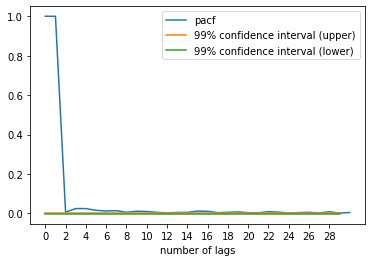

In [11]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.xticks(np.arange(0, 30, 2))
plt.legend();

In [12]:
train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

In [18]:
def make_CNN(window_size, filter_length,  nb_filter=4, nb_input_series=1, nb_outputs=1):
    """
    window_size (int): number of observations in each input sequence
    filter length (int): length of the convolutional layer's filters
    nb_filter (int): number of filters learned in the convolutional layer
    nb_input_series (int): number of features of the input timeseries (1 for a univariate timeseries)
    nb_outputs (int): number of features being predicted (equal to nb_input_series 
        for predicting a timeseries at a set horizon)
    """
    model = Sequential((
        # The convolutional layer learns `nb_filter` filters (aka kernels), 
        # each of size `(filter_length, nb_input_series)`.  
        # Its output will have shape `(None, window_size - filter_length + 1, nb_filter)` ,  
        # i.e., for each position in the input timeseries, the activation of each filter at that position.
        Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu',kernel_regularizer=l1(0.01), input_shape=(window_size, nb_input_series)),
        Flatten(),
        Dense(nb_outputs, activation='linear'), # For classification, a 'sigmoid' activation function would be used
    ))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    return model

In [13]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [14]:
x_train = get_lagged_features(df_train[use_features], n_steps, n_steps_ahead)
y_train =  df_train[target].values[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test[use_features], n_steps, n_steps_ahead)
y_test =  df_test[target].values[n_steps + n_steps_ahead - 1:]

In [15]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=3e-3, restore_best_weights=True)

In [28]:
CNN_model = make_CNN(window_size=23, filter_length=10, nb_filter=6)

In [ ]:
CNN_model.fit(x_train, y_train, epochs=1, batch_size=2,callbacks=[es], validation_data=(x_test, y_test))

Train on 826793 samples, validate on 206675 samples
Epoch 1/1
  6242/826793 [..............................] - ETA: 21:17 - loss: 0.0014 - mae: 0.0176

In [30]:
pred_train = CNN_model.predict(x_train, verbose=1)
MSE_train = mean_squared_error(y_train, pred_train)
    
pred_test = CNN_model.predict(x_test, verbose=1) 
MSE_test = mean_squared_error(y_test, pred_test)

206675/206675 [==============================] - 4s 19us/step


In [31]:
print(MSE_train,MSE_test)

0.00019226486757361743 0.0001960625022102386


In [32]:
# number of samples to use for computing test statistic
n = 100000

In [34]:
residual = y_test[-n:] - pred_test[-n:]

In [35]:
lb, p = sm.stats.diagnostic.acorr_ljungbox(residual, lags=20, boxpierce=False)

In [36]:
lb

array([ 90551.96322632, 171809.46171647, 243505.42588205, 306052.71499627,
       359779.80049853, 405100.57678194, 442521.92301082, 472520.35160383,
       495656.25823612, 512738.16300869, 524663.43691748, 532717.50450377,
       537942.12016125, 541177.01886555, 543052.15862343, 544059.81573437,
       544539.95179332, 544717.83345376, 544756.58431791, 544757.19214225])

In [37]:
p

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])